# <center>When is the best time to have team learning blocks?</center>

# Table of Contents<a class="anchor" id="top"></a>
1. [Intro](#intro)
2. [Data Cleaning](#data_cleaning)
3. [Task count by local hour of day](#hour_of_day)
4. [Task count by local day of week](#day_of_week)
5. [Task count by local hour of day and day of week for each region](#multivariate_exploration)

# Intro<a class="anchor" id="intro"></a>
This half, our team wanted to dedicate some time during the week to learn new things. During these learning blocks, we plan to block out time for learning. Ad hoc requests (I'll call these "tasks" going forward) will not be assigned when the team has a learning block. We want 4 hours per week for learning time, and each learning block should be at least an hour long.

For this project, I'll analyze task data and see which times during the week might be best for team learning blocks. My assumption is that hours during the week with the lowest volume of tasks will be best. These times should have the least impact on our stakeholders, as we'll only pick up these tasks outside of learning blocks. Our organization has teams in 3 regions. I decided to look at data for all regions combined, as well as individually. Data is from an internal table and was stored in the tasks.csv file for this analysis.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [56]:
tasks = pd.read_csv('tasks.csv')

In [57]:
tasks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4986 entries, 0 to 4985
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   task_id               4986 non-null   float64
 1   created_time          4986 non-null   int64  
 2   creation_date         4986 non-null   object 
 3   first_assigned_time   4656 non-null   float64
 4   first_comment_time    4491 non-null   float64
 5   task_owner_id         4984 non-null   float64
 6   first_comment_region  4491 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 272.8+ KB


[Back to top](#top)

# Data Cleaning<a class="anchor" id="data_cleaning"></a>
1. Check tasks with null first_assigned_time or first_comment_time. Just want to ensure that there's no issue with our task assignment system.
2. Check tasks with null task_owner_id. Perhaps these are new tasks that didn't get assigned yet.

## 1. Check tasks with null first_assigned_time or first_comment_time

### Null first_assigned_time
I did some spot checks. These tasks indeed did not have someone from our team assigned, and they were addressed by other teams. We can remove these from the data set.

In [58]:
tasks.dropna(subset=['first_assigned_time'], inplace=True)

### Null first_comment_time

I did some spot checks here as well. These tasks were closed without a comment from our team. For this analysis, I'm using the first_comment_region column to determine the region. The number of tasks without a comment from our team is relatively small, so I'll drop these as well.

In [59]:
tasks.dropna(subset=['first_comment_time'], inplace=True)

## 2. Check tasks with null task_owner_id

In [60]:
tasks[tasks['task_owner_id'].isnull()]

,task_id,created_time,creation_date,first_assigned_time,first_comment_time,task_owner_id,first_comment_region


Looks like tasks with null task_owner_id either had a null first_assigned_time or first_comment_time. These were dropped already, so we can continue on.

[Back to top](#top)

# Task count by local hour of day<a class="anchor" id="hour_of_day"></a>
To determine the best learning blocks, we probably want to look at the task volume by hour of day, and day of week, for each region. However, I wanted to start by looking at local hour of day for all regions combined to see if there are any insights first.

In [61]:
# Splitting the data set by region. To get local time, I created a datetime index column called created_time_local.
# I *think* this column can only be in one time zone within a dataframe
# Each region then derived the local hour of day and day of week from this column
# Finally, this column was dropped and the regional dataframes could then be combined

tasks_a = tasks.loc[tasks.first_comment_region == 'Region A', :].copy()
tasks_b = tasks.loc[tasks.first_comment_region == 'Region B', :].copy()
tasks_c = tasks.loc[tasks.first_comment_region == 'Region C', :].copy()

In [62]:
tasks_a.loc[:, 'created_time_local'] = pd.DatetimeIndex(pd.to_datetime(tasks_a['created_time'], unit='s', errors='coerce')).tz_localize('UTC').tz_convert('Asia/Kuala_Lumpur')
tasks_a.loc[:, 'created_time_local_hour'] = tasks_a['created_time_local'].dt.hour
tasks_a.loc[:, 'created_time_local_dow'] = tasks_a['created_time_local'].dt.dayofweek

tasks_b.loc[:, 'created_time_local'] = pd.DatetimeIndex(pd.to_datetime(tasks_b['created_time'], unit='s', errors='coerce')).tz_localize('UTC').tz_convert('Europe/London')
tasks_b.loc[:, 'created_time_local_hour'] = tasks_b['created_time_local'].dt.hour
tasks_b.loc[:, 'created_time_local_dow'] = tasks_b['created_time_local'].dt.dayofweek

tasks_c.loc[:, 'created_time_local'] = pd.DatetimeIndex(pd.to_datetime(tasks_c['created_time'], unit='s', errors='coerce')).tz_localize('UTC').tz_convert('America/Detroit')
tasks_c.loc[:, 'created_time_local_hour'] = tasks_c['created_time_local'].dt.hour
tasks_c.loc[:, 'created_time_local_dow'] = tasks_c['created_time_local'].dt.dayofweek

In [63]:
tasks_a.drop(columns=['created_time_local'], inplace=True)
tasks_b.drop(columns=['created_time_local'], inplace=True)
tasks_c.drop(columns=['created_time_local'], inplace=True)

In [64]:
tasks_local = pd.concat([tasks_a, tasks_b, tasks_c], ignore_index=True)

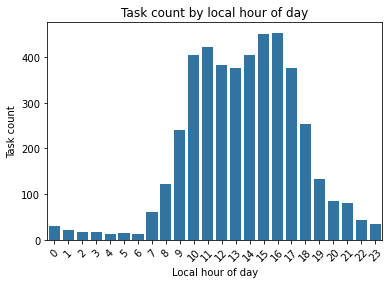

In [65]:
base_color = sb.color_palette()[0]
sb.countplot(data=tasks_local, x='created_time_local_hour', color=base_color)
plt.xticks(
    ticks = [0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0],
    labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
)
plt.xticks(rotation=45)
plt.ylabel('Task count')
plt.xlabel('Local hour of day')
plt.title('Task count by local hour of day');

Most tasks are filed during the middle of the work day. Interesting that there are still tasks coming in outside of normal working hours though.

[Back to top](#top)

# Task count by local day of week<a class="anchor" id="day_of_week"></a>
Similar to the local hour of day analysis above, I just wanted to look at task volume by local day of week for all regions combined to see if there are any insights.

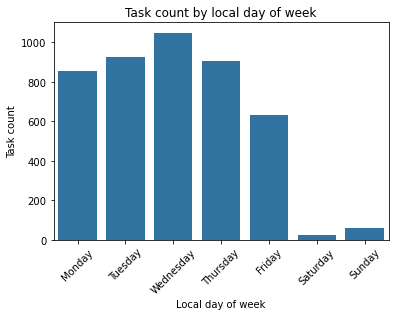

In [66]:
dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
tasks_local['created_time_local_dow'].replace([0,1,2,3,4,5,6], dow_order, inplace=True)

sb.countplot(data=tasks_local, x='created_time_local_dow', order=dow_order, color=base_color)
plt.xticks(rotation=45)
plt.ylabel('Task count')
plt.xlabel('Local day of week')
plt.title('Task count by local day of week');

Most tasks are filed from Monday through Friday. Friday is the lowest volume day during the work week. Some tasks still come in during the weekend.

[Back to top](#top)

# Task count by local hour of day and day of week for each region<a class="anchor" id="multivariate_exploration"></a>
On to the main point of the analysis. I'll use a facet grid in Seaborn to see task volume for each region and day of week individually. This will provide a quick visual indicator of which times have the lowest task volume for each region. I considered 12-1 pm as lunch hour, so that was excluded from consideration for learning blocks.

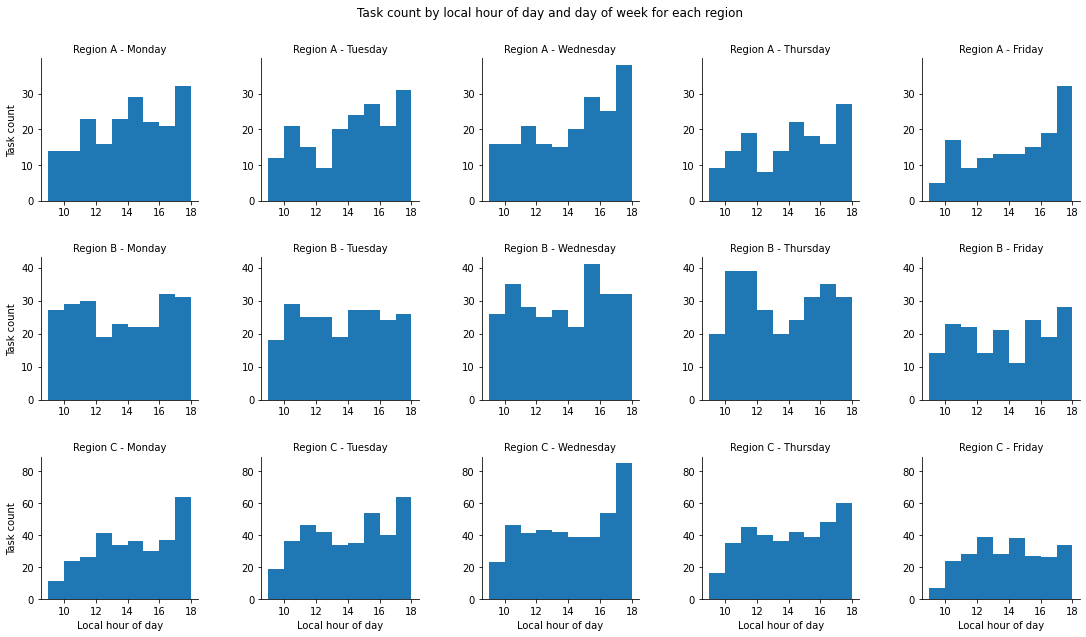

In [67]:
workweek_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
tasks_workweek = tasks_local[tasks_local['created_time_local_dow'].isin(workweek_order)].copy()

g = sb.FacetGrid(data=tasks_workweek, col='created_time_local_dow', row='first_comment_region', col_order=workweek_order, sharey='row')
g.map(plt.hist, 'created_time_local_hour', bins=[9,10,11,12,13,14,15,16,17,18])
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Task count by local hour of day and day of week for each region')
g.set_titles('{row_name} - {col_name}')
g.set_axis_labels("Local hour of day", "Task count")

for ax in g.axes.flatten():
    ax.tick_params(labelleft=True, labelbottom=True)
    
plt.subplots_adjust(wspace=0.4, hspace=0.4);

Top picks for team learning blocks for each region:
* Region A:
  * Tue, Thu 9-10 am
  * Fri 9-10 am, 11 am - 12 pm
* Region B:
  * Tue 9-10 am, 1-2 pm
  * Fri 9-10 am, 2-3 pm
* Region C:
  * Mon, Tue, Thu, Fri 9-10 am

[Back to top](#top)